# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features


In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period.
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model.
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.


## Imports & Settings


In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [54]:
MONTH = 21  # days
YEAR = 12 * MONTH  # 252 days

In [55]:
START = '2010-01-01'
END = '2017-12-31'

In [56]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [57]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]
percentiles

[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]

In [58]:
T = [1, 5, 10, 21, 42, 63]

## Loading Quandl Wiki Stock Prices & Meta Data


In [59]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              # select OHLCV columns from 2010 until 2017
              .loc[idx[START:END, :], ohlcv]
              # simplify column names
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])

In [60]:
prices.head(3)

open      close        low       high     volume
ticker date                                                             
A      2010-01-04  21.415535  21.354133  21.239108  21.579273  2729300.0
       2010-01-05  21.292732  21.122172  20.985724  21.299554  2994300.0
       2010-01-06  21.047125  21.047125  20.985724  21.149461  2320300.0

In [61]:
prices.shape, metadata.shape

((5698754, 5), (6834, 2))

In [62]:
prices.volume /= 1e3  # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations


We require at least 7 years of data; we simplify and select using both in- and out-of-sample period; please be aware that it would be more accurate to use only the training period to remove data to avoid lookahead bias.


In [63]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data


In [64]:
metadata.head(3)

,marketcap,sector
symbol,,
PIH,43090000.0,Finance
PIHPP,NaN,Finance
TURN,70330000.0,Finance


In [65]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [66]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [67]:
prices.shape, metadata.shape

((4056841, 5), (2024, 2))

### Limit universe to 1,000 stocks with highest market cap


Again, we simplify and use the entire sample period, not just the training period, to select our universe.


In [68]:
universe = metadata.marketcap.nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [69]:
metadata.sector.value_counts()

sector
consumer_services        187
finance                  168
technology               116
health_care              103
capital_goods             94
basic_industries          67
public_utilities          66
consumer_non-durables     61
energy                    51
consumer_durables         36
miscellaneous             28
transportation            23
Name: count, dtype: int64

In [70]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2004775 non-null  float64
 1   close   2004775 non-null  float64
 2   low     2004775 non-null  float64
 3   high    2004775 non-null  float64
 4   volume  2004775 non-null  float64
dtypes: float64(5)
memory usage: 84.9+ MB


In [71]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, AAPL to NTCT
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  1000 non-null   float64
 1   sector     1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


### Rank assets by Rolling Average Dollar Volume


#### Compute dollar volume


In [72]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1).div(1e3)

In [73]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  
symbol date                     
AAPL   2010-01-04  3394.794352  
       2010-01-05  4145.742393  
       2010-01-06  3742.621292

#### 21-day moving average


In [74]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1)  # 1 trading month
                 .mean())

#### Rank stocks by moving average


In [75]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                             .rank(axis=1, ascending=False)
                             .stack('symbol')
                             .swaplevel())

In [76]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2004775 non-null  float64
 1   close            2004775 non-null  float64
 2   low              2004775 non-null  float64
 3   high             2004775 non-null  float64
 4   volume           2004775 non-null  float64
 5   dollar_vol       2004775 non-null  float64
 6   dollar_vol_rank  2004775 non-null  float64
dtypes: float64(7)
memory usage: 115.5+ MB


In [77]:
prices.head()

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   
       2010-01-07  27.212826  27.062465  26.865839  27.244955  119282.8   
       2010-01-08  27.026481  27.242385  26.867124  27.244955  111902.7   

                    dollar_vol  dollar_vol_rank  
symbol date                                      
AAPL   2010-01-04  3394.794352              1.0  
       2010-01-05  4145.742393              1.0  
       2010-01-06  3742.621292              1.0  
       2010-01-07  3228.086599              1.0  
       2010-01-08  3048.496380              2.0

## Add some Basic Factors


See [appendix](../24_alpha_factor_library) for details on the below indicators.


### Compute the Relative Strength Index


In [78]:
# prices.groupby(level='symbol').close.apply(RSI)

In [79]:
prices['rsi'] = prices.groupby(level='symbol').close.apply(RSI).droplevel(0)

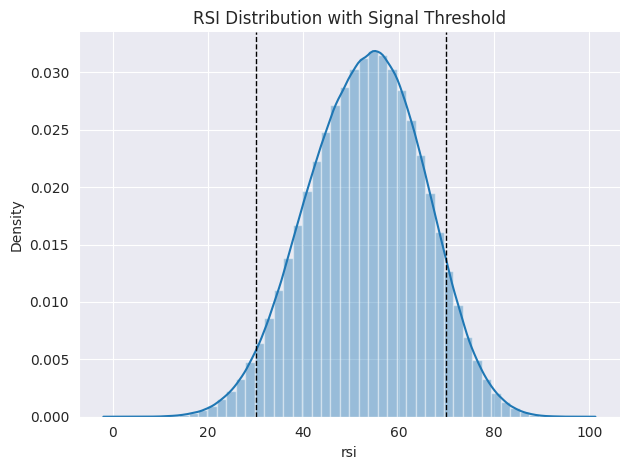

In [80]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout()

### Compute Bollinger Bands


In [81]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [87]:
prices = (prices.join(prices
                      .groupby(level='symbol')
                      .close
                      .apply(compute_bb).droplevel(0)))

In [89]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  dollar_vol_rank  rsi  bb_high  bb_low  
symbol date                                                            
AAPL   2010-01-04  3394.794352              1.0  NaN      NaN     NaN  
       2010-01-05  4145.742393              1.0  NaN      NaN     NaN  
       2010-01-06  3742.621292              1.0  NaN      NaN     NaN

In [90]:
prices['bb_high'] = prices.bb_high.sub(
    prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(
    prices.bb_low).div(prices.close).apply(np.log1p)

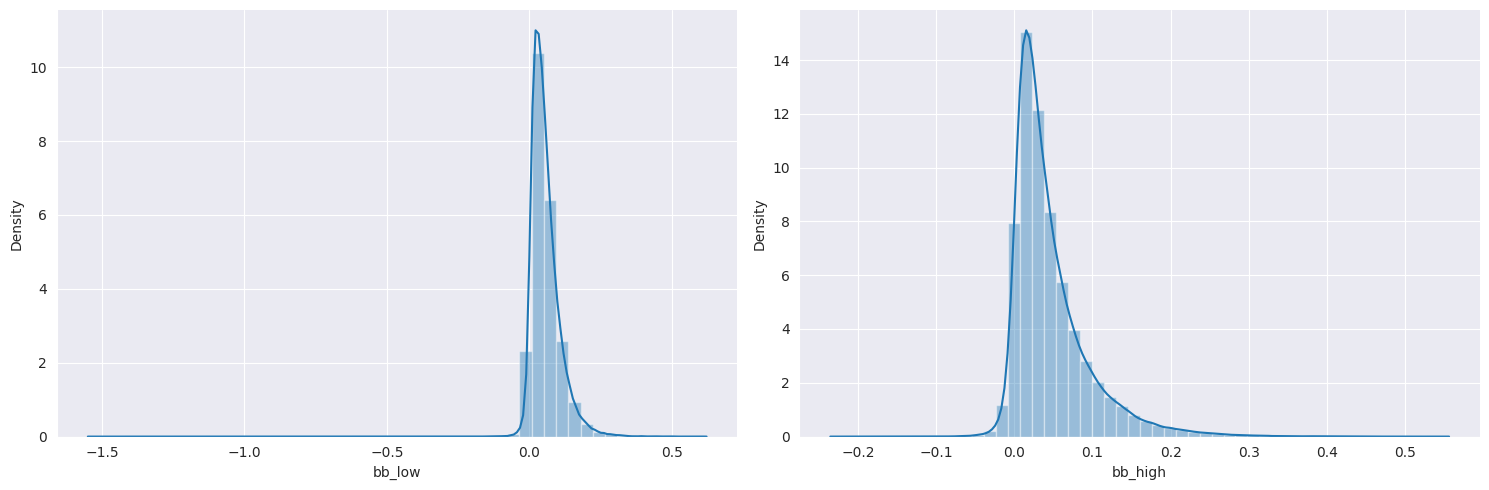

In [91]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank <
             100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank <
             100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout()

### Compute Average True Range


In [92]:
prices['NATR'] = prices.groupby(level='symbol',
                                group_keys=False).apply(lambda x:
                                                        talib.NATR(x.high, x.low, x.close))

In [93]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low,
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [94]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

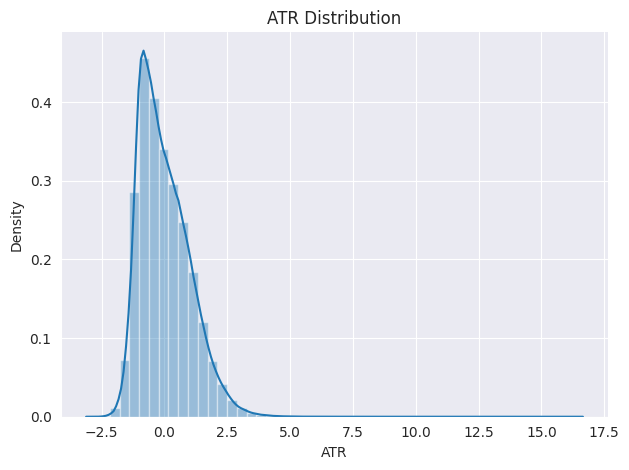

In [98]:
ax = sns.distplot(prices.ATR.dropna())
ax.set_title('ATR Distribution')
sns.despine()
plt.tight_layout()

### Compute Moving Average Convergence/Divergence


In [ ]:
prices['PPO'] = prices.groupby(
    level='symbol').close.apply(talib.PPO).droplevel(0)

In [99]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [100]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data


In [101]:
metadata.sector = pd.factorize(metadata.sector)[0].astype(int)
prices = prices.join(metadata[['sector']])

## Compute Returns


### Historical Returns


In [103]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

In [104]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  dollar_vol_rank  rsi  bb_high  bb_low  ...  \
symbol date                                                            ...   
AAPL   2010-01-04  3394.794352              1.0  NaN      NaN     NaN  ...   
       2010-01-05  4145.742393              1.0  NaN      NaN     NaN  ...   
       2010-01-06  3742.621292              1.0  NaN      NaN     NaN  ...   

                   ATR  PPO  MACD  sector       r01  r05  r10  r21  r42  r63  
symbol date                                                                   
AAPL   2010-01-04  NaN  NaN   NaN       0       NaN  NaN  NaN  NaN  NaN  NaN  
       2010-01-05  NaN  NaN   NaN       0  0.001729  NaN  NaN  NaN  NaN  NaN  
       2010-01-06  NaN  NaN   NaN       0 -0.015906  NaN  NaN  NaN  NaN  NaN  

[3 rows x 21 columns]

### Daily historical return deciles


In [106]:
for t in T:
    prices[f'r{t:02}dec'] = (prices[f'r{t:02}']
                             .groupby(level='date')
                             .apply(lambda x: pd.qcut(x,
                                                      q=10,
                                                      labels=False,
                                                      duplicates='drop')).droplevel(0))

In [107]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  dollar_vol_rank  rsi  bb_high  bb_low  ...  \
symbol date                                                            ...   
AAPL   2010-01-04  3394.794352              1.0  NaN      NaN     NaN  ...   
       2010-01-05  4145.742393              1.0  NaN      NaN     NaN  ...   
       2010-01-06  3742.621292              1.0  NaN      NaN     NaN  ...   

                   r10  r21  r42  r63  r01dec  r05dec  r10dec  r21dec  r42dec  \
symbol date                                                                     
AAPL   2010-01-04  NaN  NaN  NaN  NaN     NaN     NaN     NaN     NaN     NaN   
       2010-01-05  NaN  NaN  NaN  NaN     5.0     NaN     NaN     NaN     NaN   
       2010-01-06  NaN  NaN  NaN  NaN     1.0     NaN     NaN     NaN     NaN   

                   r63dec  
symbol date                
AAPL   2010-01-04     NaN  
       2010-01-05     NaN  
       2010-01-06     NaN  

[3 rows x 27 columns]

### Daily sector return deciles


In [108]:
for t in T:
    prices[f'r{t:02}q_sector'] = (prices
                                  .groupby(['date', 'sector'])[f'r{t:02}']
                                  .transform(lambda x: pd.qcut(x,
                                                               q=5,
                                                               labels=False,
                                                               duplicates='drop')))

### Compute Forward Returns


In [109]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(
        level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers


In [110]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  dollar_vol_rank  rsi  bb_high  bb_low  ...  \
symbol date                                                            ...   
AAPL   2010-01-04  3394.794352              1.0  NaN      NaN     NaN  ...   
       2010-01-05  4145.742393              1.0  NaN      NaN     NaN  ...   
       2010-01-06  3742.621292              1.0  NaN      NaN     NaN  ...   

                   r63dec  r01q_sector  r05q_sector  r10q_sector  r21q_sector  \
symbol date                                                                     
AAPL   2010-01-04     NaN          NaN          NaN          NaN          NaN   
       2010-01-05     NaN          3.0          NaN          NaN          NaN   
       2010-01-06     NaN          0.0          NaN          NaN          NaN   

                   r42q_sector  r63q_sector   r01_fwd   r05_fwd   r21_fwd  
symbol date                                                                
AAPL   2010-01-04          NaN          NaN  0.001729 -0.018223 -0.069062  
       2010-01-05          NaN          NaN -0.015906 -0.031066 -0.104161  
       2010-01-06          NaN          NaN -0.001849 -0.001517 -0.073518  

[3 rows x 36 columns]

In [111]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,2.003775e+06,1.999775e+06,1.994775e+06,1.983775e+06,1.962775e+06,1.941775e+06
mean,7.519751e-04,3.726962e-03,7.353932e-03,1.555927e-02,3.113691e-02,4.619119e-02
std,2.166262e-02,4.791746e-02,6.579895e-02,9.467552e-02,1.325751e-01,1.618423e-01
min,-8.757416e-01,-8.768476e-01,-8.778415e-01,-8.802285e-01,-8.867366e-01,-8.863481e-01
25%,-8.088407e-03,-1.721664e-02,-2.291896e-02,-3.045918e-02,-3.531712e-02,-3.696833e-02
50%,6.561680e-04,3.702235e-03,7.173181e-03,1.503253e-02,2.899023e-02,4.217809e-02
75%,9.509191e-03,2.440601e-02,3.707177e-02,5.927618e-02,9.305628e-02,1.219666e-01
max,1.216425e+01,1.252657e+01,1.252657e+01,1.252657e+01,1.181643e+01,1.166968e+01


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.


In [112]:
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()

In [113]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables


In [114]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data


In [115]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1994931 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 39 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1994931 non-null  float64
 1   close            1994931 non-null  float64
 2   low              1994931 non-null  float64
 3   high             1994931 non-null  float64
 4   volume           1994931 non-null  float64
 5   dollar_vol       1994931 non-null  float64
 6   dollar_vol_rank  1994931 non-null  float64
 7   rsi              1981001 non-null  float64
 8   bb_high          1976026 non-null  float64
 9   bb_low           1976022 non-null  float64
 10  NATR             1981001 non-null  float64
 11  ATR              1981001 non-null  float64
 12  PPO              1970056 non-null  float64
 13  MACD             1962096 non-null  float64
 14  sector           1994931 non-null  int

In [116]:
prices.drop(['open', 'close', 'low', 'high', 'volume'],
            axis=1).to_hdf('data.h5', 'model_data')

In [117]:
prices.head(3)

open      close        low       high    volume  \
symbol date                                                               
AAPL   2010-01-04  27.428730  27.503268  27.293790  27.566240  123432.4   
       2010-01-05  27.579091  27.550818  27.405597  27.706320  150476.2   
       2010-01-06  27.550818  27.112585  27.084312  27.660055  138040.0   

                    dollar_vol  dollar_vol_rank  rsi  bb_high  bb_low  ...  \
symbol date                                                            ...   
AAPL   2010-01-04  3394.794352              1.0  NaN      NaN     NaN  ...   
       2010-01-05  4145.742393              1.0  NaN      NaN     NaN  ...   
       2010-01-06  3742.621292              1.0  NaN      NaN     NaN  ...   

                   r10q_sector  r21q_sector  r42q_sector  r63q_sector  \
symbol date                                                             
AAPL   2010-01-04          NaN          NaN          NaN          NaN   
       2010-01-05          NaN          NaN          NaN          NaN   
       2010-01-06          NaN          NaN          NaN          NaN   

                    r01_fwd   r05_fwd   r21_fwd  year  month  weekday  
symbol date                                                            
AAPL   2010-01-04  0.001729 -0.018223 -0.069062  2010      1        0  
       2010-01-05 -0.015906 -0.031066 -0.104161  2010      1        1  
       2010-01-06 -0.001849 -0.001517 -0.073518  2010      1        2  

[3 rows x 39 columns]